# Anisotropic Model Merger Rate Sampler

In [1]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
import jax
from bilby.core.prior import PriorDict, Uniform
import jax_healpy as hp
gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline
print(jax.devices())

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2)]


# Load Posteriors
Need to remove BHNS events as they ruin the likelihood

In [2]:
Posteriors = list()
import pickle

# Load the pickled list of dictionaries
with open("O3a_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)

with open("O3b_FINAL_parameter_posteriors.pkl", "rb") as f:
    raw_event_data = pickle.load(f)

# Convert each event's dictionary into a DataFrame
for event in raw_event_data:
    # Remove the event name key — we'll store it as metadata instead
    event_name = event.pop("event", None)
    df = pd.DataFrame(event)
    df.attrs["event"] = event_name  # Store event label as metadata
    Posteriors.append(df)


# Suppose your list of DataFrames is called `dataframes`
Posteriors_filtered = [df for df in Posteriors if len(df["mass_1"]) >= 2000]


del Posteriors_filtered[67]
del Posteriors_filtered[53]
del Posteriors_filtered[46]
del Posteriors_filtered[26]

#print(Posteriors_filtered[25]['full_event'])
#for i, df in enumerate(Posteriors_filtered):
#    event_name = df.attrs.get("event", f"unnamed_event_{i}")
#    print(f"{i}: {event_name}")

for i in range(0, len(Posteriors_filtered)):
    del Posteriors_filtered[i]["full_event"] 

print(len(Posteriors_filtered))

67


# Load Injections

In [3]:
from gwpopulation_pipe.vt_helper import load_injection_data
import h5py

def load_injection_data_with_sky(vt_file, ifar_threshold=1, snr_threshold=10):
    # Call your existing standard function to get the injections dict (VTData or dict)
    injections = load_injection_data(vt_file, ifar_threshold, snr_threshold)
    
    # Open the file again to extract sky location arrays if present
    with h5py.File(vt_file, "r") as ff:
        # Try common keys for sky position in injections or events group
        ra = None
        dec = None
        if "injections" in ff and "right_ascension" in ff["injections"]:
            ra = xp.array(ff["injections"]["right_ascension"][()])
            dec = xp.array(ff["injections"]["declination"][()])
        elif "events" in ff and "right_ascension" in ff["events"].dtype.names:
            ra = xp.array(ff["events"]["right_ascension"][()])
            dec = xp.array(ff["events"]["declination"][()])
        
        # If found, apply the same selection mask as used for injections (usually `found`)
        # This assumes you have access to the `found` mask, otherwise extract it again here:
        # For now let's assume the selection mask is the same length as injections.mass_1
        
        if ra is not None and dec is not None:
            # Match the length by slicing or by assuming same order as injections.mass_1
            n = len(injections.mass_1)
            injections.ra = ra[:n]
            injections.dec = dec[:n]
        else:
            print("Warning: RA/DEC not found in the injection file.")

    return injections

injections = load_injection_data_with_sky(
    "/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5", # Full O3 run
    #"/data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12-1238166018-15843600.hdf5", # O3a only
    ifar_threshold=1.0,
    snr_threshold=10.0
)

injection_dict = dict(injections)
injection_dict["ra"] = injections.ra
injection_dict["dec"] = injections.dec

# Convert to float64 to prevent errors
def convert_vtdata_to_float64(vtdata):
    for key in vtdata.keys():
        val = vtdata[key]
        if isinstance(val, (xp.ndarray,)):
            vtdata[key] = val.astype(xp.float64)
    return vtdata

# Usage
injections = convert_vtdata_to_float64(injection_dict)

11:19 bilby INFO    : Loading VT data from /data/wiay/gw-data-releases/2023/7890437/endo3_bbhpop-LIGO-T2100113-v12.hdf5.


# Define sky model in terms of spherical harmonics

In [14]:
from jax.scipy.special import sph_harm_y

def make_sky_model_class_jax(max_l: int, n_grid_theta=100, n_grid_phi=200):
    # Spherical harmonic indices to use (only m >= 0 explicitly)
    lm_list = [(l, m) for l in range(max_l + 1) for m in range(l + 1)]

    # Precompute a uniform grid over the sphere for integration
    theta_grid = xp.linspace(0, xp.pi, n_grid_theta)
    phi_grid = xp.linspace(0, 2 * xp.pi, n_grid_phi)
    theta_mesh, phi_mesh = xp.meshgrid(theta_grid, phi_grid, indexing="ij")

    # Flatten the grid for harmonic evaluation
    theta_flat = theta_mesh.reshape(-1)
    phi_flat = phi_mesh.reshape(-1)

    # Precompute harmonics on the integration grid
    Y_basis_integral = {}
    for l, m in lm_list:
        n_arr = xp.full(theta_flat.shape, l, dtype=int)
        m_arr_pos = xp.full(theta_flat.shape, m, dtype=int)
        Y_pos = sph_harm_y(n_arr, m_arr_pos, theta_flat, phi_flat, n_max=max_l)
        Y_basis_integral[(l, m)] = Y_pos
        if m > 0:
            m_arr_neg = xp.full(theta_flat.shape, -m, dtype=int)
            Y_neg = sph_harm_y(n_arr, m_arr_neg, theta_flat, phi_flat, n_max=max_l)
            Y_basis_integral[(l, -m)] = Y_neg

    sin_theta = xp.sin(theta_flat)

    class SkyModel:
        def __init__(self, dataset, **params):
            ra = dataset["ra"]
            dec = dataset["dec"]
            phi = ra
            theta = xp.pi / 2 - dec
            theta_flat_data = theta.reshape(-1)
            phi_flat_data = phi.reshape(-1)

            Y_sum = xp.zeros_like(theta_flat_data, dtype=xp.complex64)

            for l, m in lm_list:
                real = params.get(f"re_{l}_{m}", 0.0)
                if m == 0:
                    coeff = real
                else:
                    imag = params.get(f"im_{l}_{m}", 0.0)
                    coeff = real + 1j * imag

                n_arr_data = xp.full_like(theta_flat_data, l, dtype=int)
                m_arr_pos = xp.full_like(theta_flat_data, m, dtype=int)
                Y_pos = sph_harm_y(n_arr_data, m_arr_pos, theta_flat_data, phi_flat_data, n_max=max_l)
                Y_sum += coeff * Y_pos

                if m > 0:
                    m_arr_neg = xp.full(theta_flat_data.shape, -m, dtype=int)
                    Y_neg = sph_harm_y(n_arr_data, m_arr_neg, theta_flat_data, phi_flat_data, n_max=max_l)
                    Y_sum += xp.conj(coeff) * Y_neg

            probs_flat = xp.exp(Y_sum.real)

            # Now compute normalisation using precomputed grid
            Y_sum_int = xp.zeros_like(theta_flat, dtype=xp.complex64)
            for l, m in lm_list:
                real = params.get(f"re_{l}_{m}", 0.0)
                if m == 0:
                    coeff = real
                else:
                    imag = params.get(f"im_{l}_{m}", 0.0)
                    coeff = real + 1j * imag

                Y_pos = Y_basis_integral[(l, m)]
                Y_sum_int += coeff * Y_pos
                if m > 0:
                    Y_neg = Y_basis_integral[(l, -m)]
                    Y_sum_int += xp.conj(coeff) * Y_neg

            probs_int = xp.exp(Y_sum_int.real)

            dtheta = xp.pi / n_grid_theta
            dphi = 2 * xp.pi / n_grid_phi
            weights = dtheta * dphi * sin_theta
            norm = xp.sum(probs_int * weights)

            probs_flat /= norm/(4*xp.pi)
            self.result = probs_flat.reshape(ra.shape)

        def __call__(self):
            return self.result

    # Add parameter names
    variable_names = []
    for l in range(max_l + 1):
        for m in range(l + 1):
            variable_names.append(f"re_{l}_{m}")
            if m > 0:
                variable_names.append(f"im_{l}_{m}")
    SkyModel.variable_names = variable_names
    SkyModel._required_parameters = variable_names

    return SkyModel


def make_sky_model_function_jax(max_l: int):
    SkyModelClass = make_sky_model_class_jax(max_l)

    def sky_model_function(data, **params):
        model_instance = SkyModelClass(data, **params)
        return model_instance()

    sky_model_function.variable_names = SkyModelClass.variable_names
    sky_model_function._required_parameters = SkyModelClass._required_parameters
    return sky_model_function

# Example: define the function for a maximum spherical harmonic degree l=2
sky_model_function = make_sky_model_function_jax(max_l=3)


# Define Priors
Need to find good numbers and replace with delta functions for all but sky model.

# Firstly, create Dirichlet prior to uniformly sample the N-1 Simplex:

In [15]:
from bilby.core.prior import Uniform, PriorDict

max_l = 3  # or any desired maximum l

priors = PriorDict()

# Existing priors...
priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
priors["mmin"] = Uniform(minimum=2, maximum=2.5, latex_label="$m_{\\min}$")
priors["mmax"] = Uniform(minimum=80, maximum=100, latex_label="$m_{\\max}$")
priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
priors["gaussian_mass_maximum"] = 100

priors["amax"] = 1
priors["alpha_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$")
priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
priors["sigma_spin"] = Uniform(minimum=0.3, maximum=4, latex_label="$\\sigma$")

priors["lamb"] = Uniform(minimum=-1, maximum=10, latex_label="$\\lambda_{z}$")

# --- Add spherical harmonic parameters ---
for l in range(max_l + 1):
    for m in range(l + 1):
        name_re = f"re_{l}_{m}"
        priors[name_re] = Uniform(minimum=-5, maximum=5, latex_label=f"$Re_{{{l},{m}}}$")
        if m > 0:
            name_im = f"im_{l}_{m}"
            priors[name_im] = Uniform(minimum=-5, maximum=5, latex_label=f"$\\Im_{{{l},{m}}}$")


In [46]:
priors.sample()

{'alpha': 2.231583256728074,
 'beta': 5.628860838487814,
 'mmin': 2.2350369939369528,
 'mmax': 99.3902290435523,
 'lam': 0.42844721110608663,
 'mpp': 20.192423064880245,
 'sigpp': 8.431033213901314,
 'gaussian_mass_maximum': 100.0,
 'amax': 1.0,
 'alpha_chi': 2.5502661352263267,
 'beta_chi': 5.462408519798199,
 'xi_spin': 0.11100073959258705,
 'sigma_spin': 1.5624665003840799,
 'lamb': 6.6379685470496215,
 're_0_0': 1.024624796810528,
 're_1_0': -1.4386095780340469,
 're_1_1': 3.4626364235350433,
 'im_1_1': -3.7624766972764547,
 're_2_0': 1.445299847008977,
 're_2_1': 3.481503217189454,
 'im_2_1': -0.8919113731989405,
 're_2_2': -3.7555916282429402,
 'im_2_2': -0.9902938047564911,
 're_3_0': -3.5803060671144706,
 're_3_1': -4.0886883381707575,
 'im_3_1': -4.34680594258733,
 're_3_2': 2.5291779596937687,
 'im_3_2': -4.831352514910664,
 're_3_3': 3.4869704928566385,
 'im_3_3': 1.166236525865358}

# Define combined model, selection function, and likelihood

In [16]:
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel

# Wrap models into a NonCachingModel object
model = NonCachingModel(
    model_functions=[
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
        gwpop.models.redshift.PowerLawRedshift(cosmo_model="Planck15"),
        sky_model_function,
    ],
)

# Define vt function
vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(Posteriors_filtered))

# Define hyperlikelihood
likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=Posteriors_filtered,
    hyper_prior=model,
    selection_function=vt,
    max_samples = 1000,
)

11:59 bilby INFO    : No prior values provided, defaulting to 1.


# Test likelihood

In [17]:
# Sample from the prior
parameters = priors.sample()
likelihood.parameters.update(parameters)
likelihood.log_likelihood_ratio()
%time print(likelihood.log_likelihood_ratio())

# Define just-in-time compiled version (uses JAX)
jit_likelihood = JittedLikelihood(likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-448.4015800204372
CPU times: user 339 ms, sys: 163 ms, total: 502 ms
Wall time: 220 ms
-448.4015800204371
CPU times: user 58.8 s, sys: 2.02 s, total: 1min
Wall time: 24 s
-448.4015800204371
CPU times: user 8.65 ms, sys: 2.81 ms, total: 11.5 ms
Wall time: 4.23 ms


In [18]:
result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=200,
    label="l3_200_norm",
    outdir="Harmonics",
    sample="acceptance-walk",
    naccept=5,
    save="pkl",
)



12:00 bilby INFO    : Running for label 'l3_200_norm', output will be saved to 'Harmonics'
/data/wiay/undergrads/2640787g/BHIsotropy/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
12:00 bilby INFO    : Analysis priors:
12:00 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
12:00 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
12:00 bilby INFO    : mmin=Uniform(minimum=2, maximum=2.5, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
12:00 bilby INFO    : mmax=Uniform(minimum=80, maximum=100, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
12:0

1it [00:00, ?it/s]

12:05 bilby INFO    : Written checkpoint file Harmonics/l3_200_norm_resume.pickle
12:05 bilby INFO    : Rejection sampling nested samples to obtain 1570 posterior samples
12:05 bilby INFO    : Sampling time: 0:04:39.037639
12:05 bilby INFO    : Summary of results:
nsamples: 1570
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.369
ln_bayes_factor: -246.922 +/-  0.369



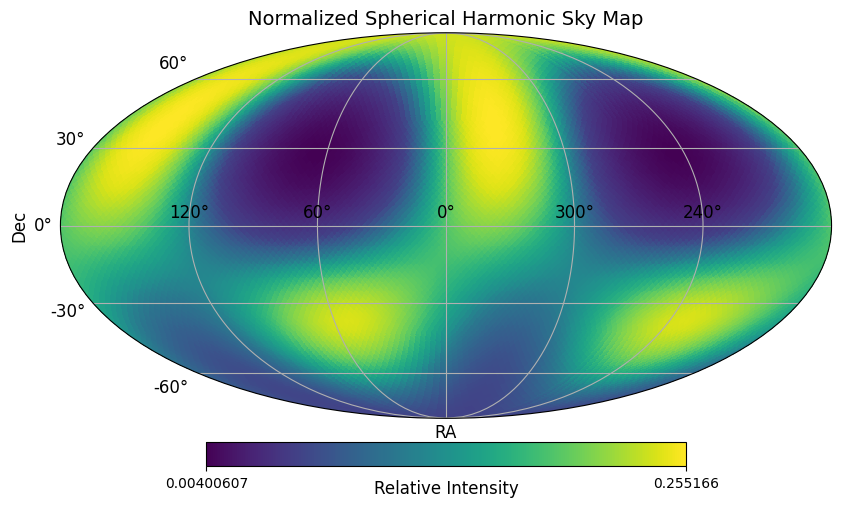

1.0088971567193852


In [19]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from jax.scipy.special import sph_harm_y
from jax import device_get

# 1. Load Bilby result
from bilby.core.result import read_in_result
result = read_in_result("Harmonics/l3_200_norm_result.pkl")

# 2. Determine max l
parameter_names = result.posterior.columns
lm_terms = [name for name in parameter_names if name.startswith("re_")]
max_l = max(int(name.split("_")[1]) for name in lm_terms)

# 3. Choose a posterior sample (e.g., median)
sample = result.posterior.mean()

# 4. HEALPix grid for evaluation
nside = 32
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))  # theta = colatitude, phi = longitude
theta_jax = xp.array(theta)
phi_jax = xp.array(phi)

# 5. Evaluate spherical harmonic sum on HEALPix grid
Y_sum = xp.zeros_like(theta_jax, dtype=xp.complex64)

for l in range(max_l + 1):
    for m in range(l + 1):
        real = sample.get(f"re_{l}_{m}", 0.0)
        if m == 0:
            coeff = real
        else:
            imag = sample.get(f"im_{l}_{m}", 0.0)
            coeff = real + 1j * imag

        n_arr = xp.full_like(theta_jax, l, dtype=int)

        m_pos_arr = xp.full_like(theta_jax, m, dtype=int)
        Y_pos = sph_harm_y(n_arr, m_pos_arr, theta_jax, phi_jax, n_max=max_l)
        Y_sum += coeff * Y_pos

        if m > 0:
            m_neg_arr = xp.full_like(theta_jax, -m, dtype=int)
            Y_neg = sph_harm_y(n_arr, m_neg_arr, theta_jax, phi_jax, n_max=max_l)
            Y_sum += xp.conj(coeff) * Y_neg

probs = xp.exp(Y_sum.real)

# 6. Compute normalization via integration over a fine grid
n_grid_theta = 100
n_grid_phi = 200
theta_grid = xp.linspace(0, xp.pi, n_grid_theta)
phi_grid = xp.linspace(0, 2 * xp.pi, n_grid_phi)
theta_mesh, phi_mesh = xp.meshgrid(theta_grid, phi_grid, indexing="ij")
theta_flat = theta_mesh.reshape(-1)
phi_flat = phi_mesh.reshape(-1)
sin_theta = xp.sin(theta_flat)

# Harmonic sum on integration grid
Y_int = xp.zeros_like(theta_flat, dtype=xp.complex64)

for l in range(max_l + 1):
    for m in range(l + 1):
        real = sample.get(f"re_{l}_{m}", 0.0)
        if m == 0:
            coeff = real
        else:
            imag = sample.get(f"im_{l}_{m}", 0.0)
            coeff = real + 1j * imag

        n_arr = xp.full_like(theta_flat, l, dtype=int)

        m_pos_arr = xp.full_like(theta_flat, m, dtype=int)
        Y_pos = sph_harm_y(n_arr, m_pos_arr, theta_flat, phi_flat, n_max=max_l)
        Y_int += coeff * Y_pos

        if m > 0:
            m_neg_arr = xp.full_like(theta_flat, -m, dtype=int)
            Y_neg = sph_harm_y(n_arr, m_neg_arr, theta_flat, phi_flat, n_max=max_l)
            Y_int += xp.conj(coeff) * Y_neg

probs_int = xp.exp(Y_int.real)

dtheta = xp.pi / n_grid_theta
dphi = 2 * xp.pi / n_grid_phi
weights = dtheta * dphi * sin_theta
norm = xp.sum(probs_int * weights)


# 7. Normalize
probs_normalized = probs / norm

# 8. Convert to NumPy for plotting
intensity = device_get(probs_normalized)

# 9. Plot using projview
hp.projview(
    intensity,
    coord='C',
    projection_type='mollweide',
    graticule=True,
    graticule_labels=True,
    title='Normalized Spherical Harmonic Sky Map',
    unit='Relative Intensity',
    cmap='viridis',
    xlabel='RA',
    ylabel='Dec',
    cbar=True,
    flip='astro',
    norm='hist',
)

plt.show()

total = np.sum(intensity) * (4 * np.pi / npix)
print(total)


In [ ]:
# Load the result file (replace with your actual filename)
result = bb.result.read_in_result('Harmonics/l3_500_result.pkl')

# List of parameters to exclude
exclude_params = [
    "alpha", "beta", "mmin", "mmax", "lam", "mpp", "sigpp", "gaussian_mass_maximum",
    "amax", "alpha_chi", "beta_chi", "xi_spin", "sigma_spin", "lamb", "log_likelihood", "prior"
]

# Get the list of parameters to include in the corner plot
plot_params = [param for param in result.posterior.columns if param not in exclude_params]

# Make the corner plot
result.plot_corner()

# Show the plot
plt.show()

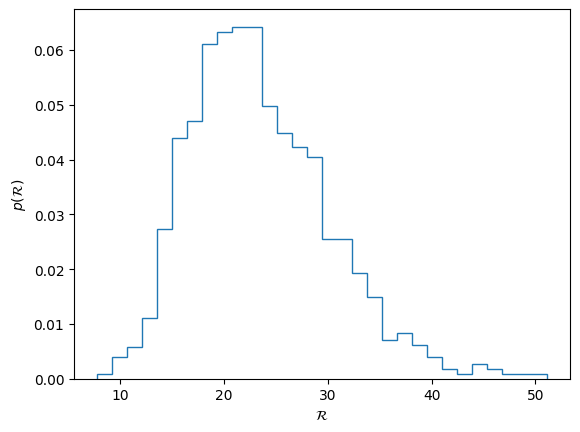

In [20]:
result = bb.result.read_in_result('Harmonics/l3_200_norm_result.pkl')

rates = list()
for ii in range(len(result.posterior)):
    likelihood.parameters.update(dict(result.posterior.iloc[ii]))
    rates.append(float(likelihood.generate_rate_posterior_sample()))
result.posterior["rate"] = rates

plt.hist(rates, bins=30, histtype="step", density=True)
plt.xlabel("${\\cal R}$")
plt.ylabel("$p({\\cal R})$")
plt.show()
plt.close()

In [10]:
with open("Full_tests/O3_ANISO_1000_result_updated.pkl", "wb") as f:
    pickle.dump(result, f)

# Euler Angle Correction



In [11]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

# Setup
Npix = 12
nside = hp.npix2nside(Npix)
npix = hp.nside2npix(nside)

n_samples = len(result.posterior)
pixel_rate_posteriors = np.zeros((n_samples, Npix))

# Get pixel center vectors in the model basis
vec_model = np.asarray(hp.pix2vec(nside, np.arange(Npix)))  # shape (3, 12)
vec_model = vec_model.T  # shape (12, 3)

# Loop through posterior samples
for i in tqdm(range(n_samples)):
    # Get sampled weights
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(Npix - 1)]
    w_last = 1.0 - sum(weights)
    weights.append(w_last)
    weights = np.asarray(weights)

    # Total rate for this sample
    R_tot = result.posterior["rate"].iloc[i]
    rates_rotated = weights * R_tot

    # Euler angles
    alpha = result.posterior["a"].iloc[i]
    beta = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]

    # Build rotation to orient each sample map correctly
    rotation = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_celestial = rotation.inv().apply(vec_model)  # shape (12, 3)

    # Convert rotated vectors to spherical angles
    theta_new, phi_new = hp.vec2ang(vec_celestial.T)

    # Interpolate to get celestial frame rates
    map_rotated = np.zeros(npix)
    map_rotated[:Npix] = rates_rotated
    pix_indices = hp.vec2pix(nside, vec_celestial[:, 0], vec_celestial[:, 1], vec_celestial[:, 2])

    pixel_rate_posteriors[i, :] = 0.0
    for j, pix in enumerate(pix_indices):
        pixel_rate_posteriors[i, pix] += rates_rotated[j]




100%|██████████| 9740/9740 [00:02<00:00, 4386.00it/s]


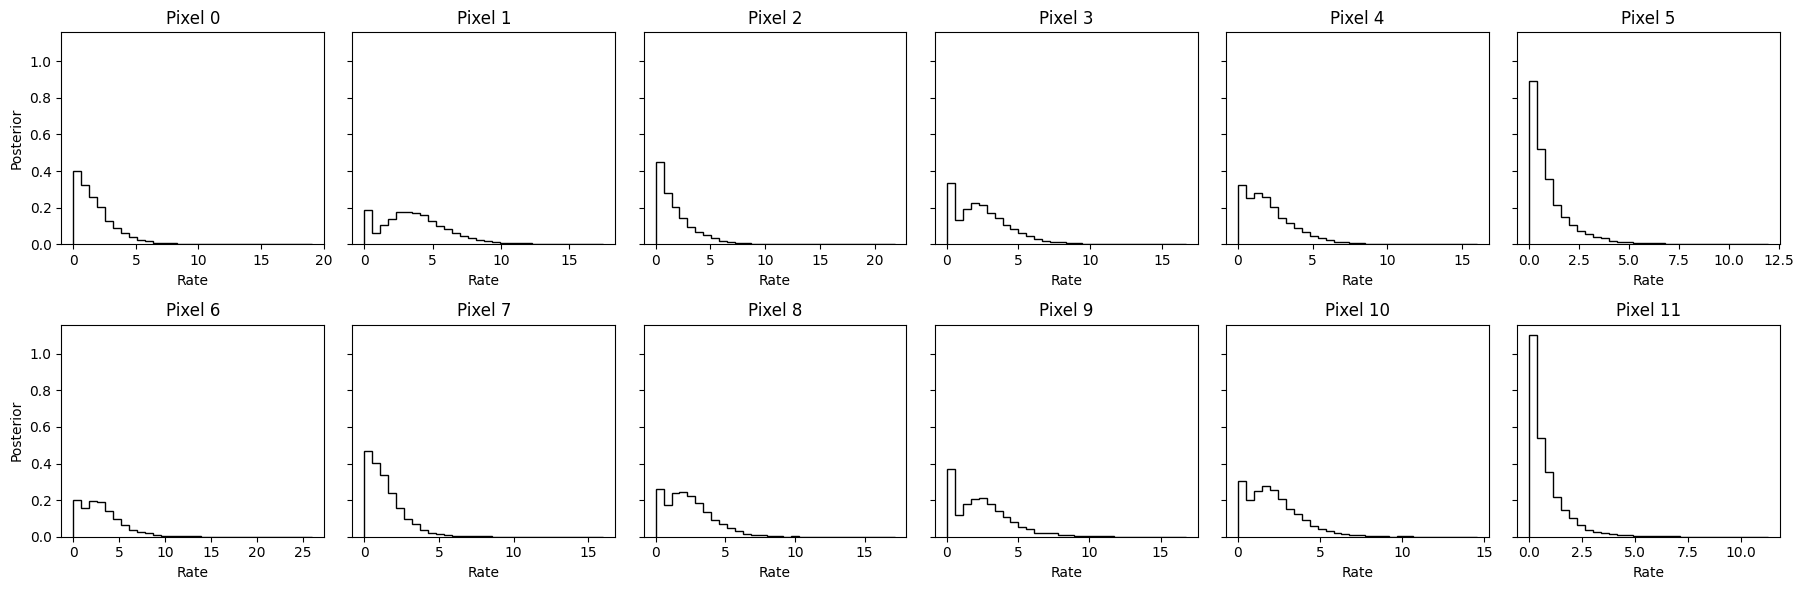

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 6, figsize=(18, 6), sharey=True)

for i in range(12):
    ax = axes[i // 6, i % 6]
    ax.hist(pixel_rate_posteriors[:, i], bins=30, histtype='step', color='black', density=True)
    ax.set_title(f"Pixel {i}")
    ax.set_xlabel("Rate")
    if i % 6 == 0:
        ax.set_ylabel("Posterior")

plt.tight_layout()
plt.show()


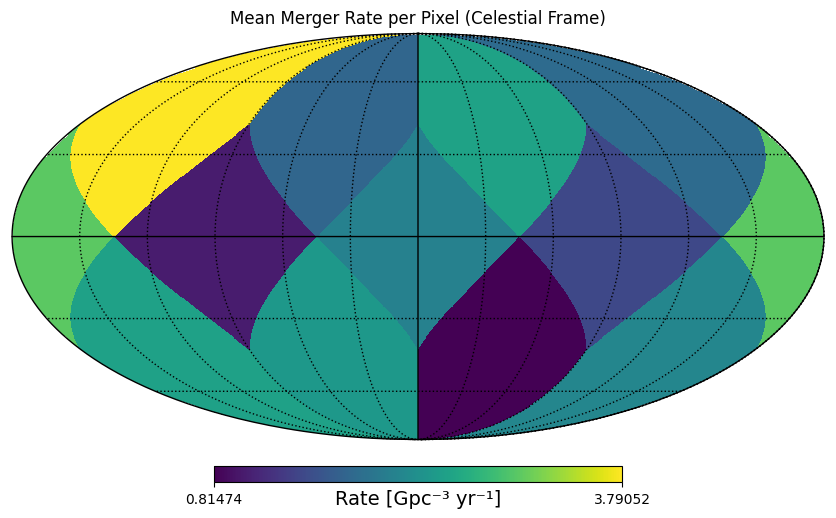

25.562297844782854


In [13]:
# Step 1: Mean rate in each pixel (celestial frame)
mean_rates = np.mean(pixel_rate_posteriors, axis=0)

# Step 2: Create full HEALPix map
nside = hp.npix2nside(12)
npix = hp.nside2npix(nside)
map_to_plot = np.full(npix, hp.UNSEEN)  # Fill all with unseen
map_to_plot[:12] = mean_rates           # Set only the 12 pixels we used

# Step 3: Mollweide plot
hp.mollview(
    map_to_plot,
    title="Mean Merger Rate per Pixel (Celestial Frame)",
    unit="Rate [Gpc⁻³ yr⁻¹]",
    cmap="viridis",
    #min=0,
    #max=np.max(mean_rates)
)
hp.graticule()
plt.show()

print(np.sum(mean_rates))

# Euler Correction with smoothing onto Nside=64 basis

100%|██████████| 9740/9740 [00:16<00:00, 595.61it/s]
/data/wiay/undergrads/2640787g/tmp/pip-build/ipykernel_2811219/3357014421.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')  # Choose a non-viridis colormap


25.562297844782794


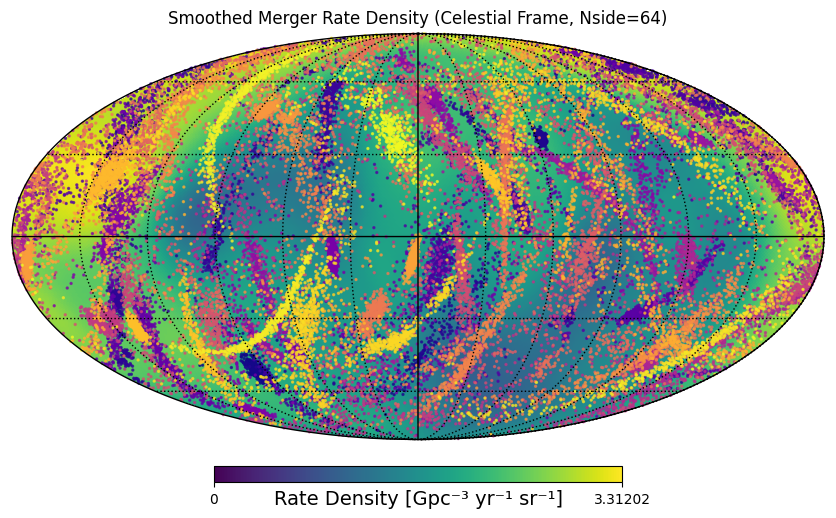

In [16]:
import healpy as hp
import numpy as np
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
from matplotlib import cm

# Parameters
nside_model = 1        # model basis (12 pixels)
nside_target = 64      # high-res common basis
npix_model = hp.nside2npix(nside_model)
npix_target = hp.nside2npix(nside_target)

# Get model pixel center vectors
vec_model = np.asarray(hp.pix2vec(nside_model, np.arange(npix_model))).T  # shape (12, 3)

# High-res map to accumulate results
pdf_map = np.zeros(npix_target)

# Loop through posterior samples
n_samples = len(result.posterior)

for i in tqdm(range(n_samples)):

    # === 1. Get sample weights ===
    weights = [result.posterior[f"w_{j}"].iloc[i] for j in range(npix_model - 1)]
    weights.append(1.0 - sum(weights))
    weights = np.asarray(weights)
    rate = result.posterior["rate"].iloc[i]
    pixel_rates = weights * rate

    # === 2. Get Euler angles and rotate model pixel centers ===
    alpha = result.posterior["a"].iloc[i]
    beta  = result.posterior["b"].iloc[i]
    gamma = result.posterior["c"].iloc[i]
    rot = R.from_euler("ZYZ", [alpha, beta, gamma], degrees=False)
    vec_rotated = rot.inv().apply(vec_model)  # shape (12, 3)

    # === 3. For each model pixel, distribute to target pixels it overlaps ===
    for j in range(npix_model):
        # Find all high-res pixels whose center lies within the area of the rotated model pixel
        # We'll use a radius slightly larger than the pixel radius to be conservative
        pixel_radius = hp.max_pixrad(nside_model)  # angular radius in radians (~57.3 deg for Nside=1)
        idx_hit = hp.query_disc(
            nside_target,
            vec_rotated[j],
            pixel_radius,
            inclusive=True,
            fact=4
        )

        if len(idx_hit) > 0:
            # Distribute pixel rate equally among those overlapping high-res pixels
            contribution = pixel_rates[j] / len(idx_hit)
            pdf_map[idx_hit] += contribution

# === 4. Normalize by number of samples ===
pdf_map /= n_samples

# === 5. Convert to rate density [Gpc⁻³ yr⁻¹ sr⁻¹], optional ===
# pixel area in steradians:
pix_area_sr = hp.nside2pixarea(nside_target)
rate_density_map = pdf_map / pix_area_sr



# Prepare scatter data
all_ra = []
all_dec = []

for df in Posteriors_filtered:
    sampled = df.sample(n=min(500, len(df)))
    all_ra.append(sampled['ra'].values)
    all_dec.append(sampled['dec'].values)

ra = xp.concatenate(all_ra)
dec = xp.concatenate(all_dec)

# Convert to theta/phi (Healpy convention)
theta = 0.5 * xp.pi - dec  # dec to theta
phi = ra                   # ra is phi

# Generate a color gradient (different from 'viridis')
scatter_vals = xp.linspace(0, 1, len(theta))
cmap = cm.get_cmap('plasma')  # Choose a non-viridis colormap
colors = cmap(scatter_vals)


# === 6. Plot ===
hp.mollview(
    rate_density_map,
    title="Smoothed Merger Rate Density (Celestial Frame, Nside=64)",
    unit="Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]",
    cmap="viridis",
    min=0,
    #max=np.percentile(pdf_map, 99)  # adjust max if needed
)

hp.projscatter(theta, phi, lonlat=False, c=colors, s=2, alpha=0.7)
hp.graticule()
print(np.sum(pdf_map))


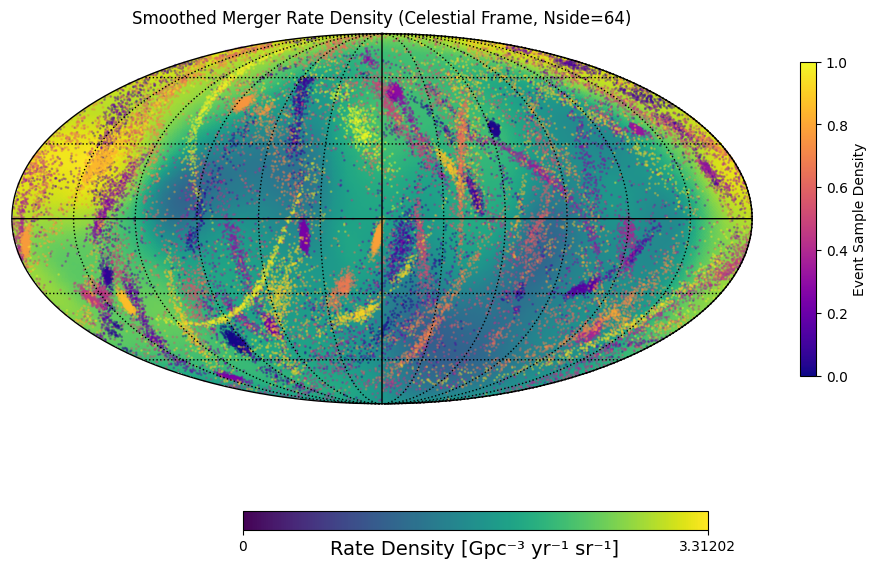

In [ ]:
import matplotlib.pyplot as plt

# === 6. Plot using healpy with matplotlib support ===
fig = plt.figure(figsize=(12, 8))

# Plot the Healpy map (uses subplot 1 automatically)
hp.mollview(
    rate_density_map,
    title="Smoothed Merger Rate Density (Celestial Frame, Nside=64)",
    unit="Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]",
    cmap="viridis",
    min=0,
    # max=np.percentile(pdf_map, 99),
    hold=True  # required to keep matplotlib context
)

# Project the scatter points
sc = hp.projscatter(theta, phi, lonlat=False, c=scatter_vals, cmap='plasma', s=1, alpha=0.3)

# Add the Healpy graticule
hp.graticule()

# === 7. Add a second colorbar manually for the scatter ===
# Get the matplotlib axis from the Healpy map
ax = plt.gca()

# Create a fake ScalarMappable to use for the scatter colorbar
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])

# Define colorbar for scatter
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
cbar.set_label('Event Sample Density')  # or something more meaningful

plt.show()


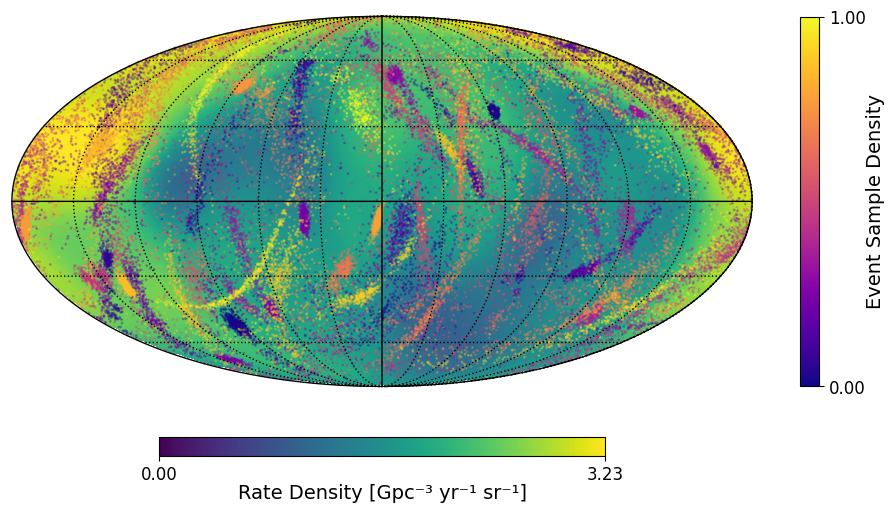

In [36]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import healpy as hp
import numpy as np

# === Create figure ===
fig = plt.figure(figsize=(12, 8))

# === Plot healpy map with no default colorbar ===
hp.mollview(
    rate_density_map,
    title = "",
    unit="",              # prevents default unit label
    cmap="viridis",
    min=0,
    max=np.percentile(rate_density_map, 99),
    cbar=False,           # disable default colorbar
    hold=True
)

# === Add scatter overlay ===
hp.projscatter(theta, phi, lonlat=False, c=scatter_vals, cmap='plasma', s=1, alpha=0.3)
hp.graticule()

# === Get current axis used by healpy ===
ax = plt.gca()

# === Add vertical scatter colorbar ===
norm_scatter = Normalize(vmin=0, vmax=1)
sm_scatter = ScalarMappable(cmap='plasma', norm=norm_scatter)
sm_scatter.set_array([])

cbar_scatter = plt.colorbar(sm_scatter, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)

# Show only first and last ticks on scatter colorbar
ticks_scatter = [0, 1]
cbar_scatter.set_ticks(ticks_scatter)
cbar_scatter.set_ticklabels([f"{tick:.2f}" for tick in ticks_scatter])

# Bigger label font and closer label
cbar_scatter.set_label('Event Sample Density', fontsize=14, labelpad=0.5)
cbar_scatter.ax.tick_params(labelsize=12)

# === Add horizontal colorbar for the map ===
cbax = inset_axes(
    ax,
    width="60%",          # width relative to map width
    height="5%",          # height of colorbar
    loc='lower center',   # anchor under map
    bbox_to_anchor=(0.0, -0.18, 1, 1),  # position relative to map axis
    bbox_transform=ax.transAxes,
    borderpad=0
)

vmin_map = 0
vmax_map = np.percentile(rate_density_map, 99)
norm_map = Normalize(vmin=vmin_map, vmax=vmax_map)
sm_map = ScalarMappable(cmap='viridis', norm=norm_map)
sm_map.set_array([])

cbar_map = plt.colorbar(sm_map, cax=cbax, orientation='horizontal')

# Show only first and last ticks on map colorbar
ticks_map = [vmin_map, vmax_map]
cbar_map.set_ticks(ticks_map)
cbar_map.set_ticklabels([f"{tick:.2f}" for tick in ticks_map])

# Bigger label font and closer label
cbar_map.set_label("Rate Density [Gpc⁻³ yr⁻¹ sr⁻¹]", fontsize=14, labelpad=0.5)
cbar_map.ax.tick_params(labelsize=12)

# === Adjust layout ===
plt.subplots_adjust(bottom=0.2, top=0.95)

plt.show()


In [38]:
#iso_result = bb.result.read_in_result('outdir/O3_hyper_test_result.pkl')
#aniso_result = bb.result.read_in_result('outdir/O3a_Px12_result.pkl')
iso_result = bb.result.read_in_result('Full_tests/O3_ISO_1000_result.pkl')
aniso_result = bb.result.read_in_result('Full_tests/O3_ANISO_1000_result.pkl')

# define log evidences and errors for isotropic / anisotropic models
iso_log_evid, iso_log_evid_err = iso_result.log_evidence, iso_result.log_evidence_err
aniso_log_evid, aniso_log_evid_err = aniso_result.log_evidence, aniso_result.log_evidence_err

Log_BF_iso, Log_BF_aniso = iso_result.log_bayes_factor, aniso_result.log_bayes_factor

BF = np.exp(Log_BF_iso - Log_BF_aniso)

BF_err = BF * np.sqrt(iso_log_evid_err**2 + aniso_log_evid_err**2)

print("The Bayes factor (ISO/ANISO) is", BF, "+/-", BF_err)
print(xp.exp(iso_result.log_bayes_factor - aniso_result.log_bayes_factor))

The Bayes factor (ISO/ANISO) is 3.9584932649541003 +/- 0.8331710576044059
3.9584932649541
